In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('bitome2')
sys.path.append('')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

In [2]:
#K12_DATA_PATH = Path('data/bitome2/mg1655')
K12_DATA_PATH = Path('mg1655')

In [3]:
K12_DATA_PATH

WindowsPath('data/bitome2/mg1655')

In [4]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [5]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# TU table

In [6]:
bitome_genbank = Bitome('NC_000913.3.gb')
tu_table = pd.read_csv('TU_table.csv')

In [7]:
tu_table = tu_table.set_index('locus_tag')
tu_table

,Unnamed: 0,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,,
ECK120008913,0,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,1,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,2,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,3,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,4,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...,...
ECK125285343,3668,argH,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4156850.0,4158223.0
ECK125285344,3669,aroD,1.0,1774571.0,Sigma70,1774561.0,1774566.0,1774535.0,1774540.0,1774571.0,1775444.0
ECK125285345,3670,yihUTS,-1.0,4073606.0,Sigma70,NaN,NaN,NaN,NaN,4070515.0,4073606.0


# Frequency distributions

In [8]:
tss_box_10 =[]
box_10_len = []
spacer = []
box_35_len = []

for index, row in tu_table.iterrows():
    tss, box_10_left, box_10_right, box_35_left, box_35_right, strand = row['tss'], row['box_10_left'], row['box_10_right'], row['box_35_left'], row['box_35_right'], row['strand']

    if strand == 1:
        
        tss_box_10.append(tss - box_10_right)
        box_10_len.append(box_10_right - box_10_left)
        spacer.append(-box_35_right + box_10_left)
        box_35_len.append(box_35_right - box_35_left)
        
    elif strand == -1:
        
        tss_box_10.append(box_10_left - tss)
        box_10_len.append(box_10_right - box_10_left)
        spacer.append(box_35_left - box_10_right)
        box_35_len.append(box_35_right - box_35_left)
        
    else:
        
        tss_box_10.append(0)
        box_10_len.append(0)
        spacer.append(0)
        box_35_len.append(0)

Text(0, 0.5, 'Frequency')

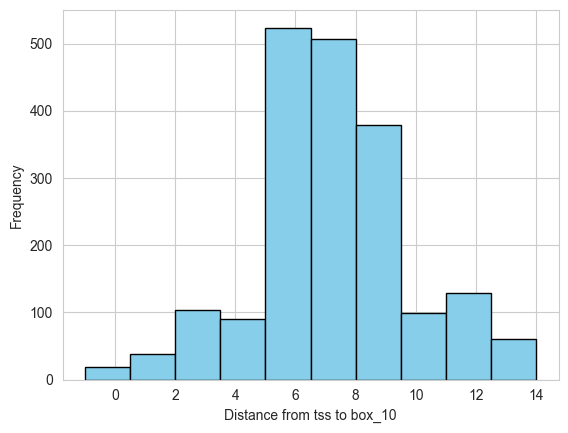

In [9]:
plt.hist(tss_box_10, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Distance from tss to box_10')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

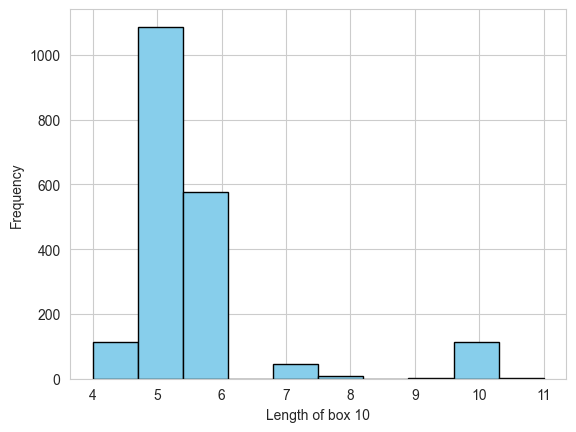

In [10]:
plt.hist(box_10_len, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Length of box 10')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

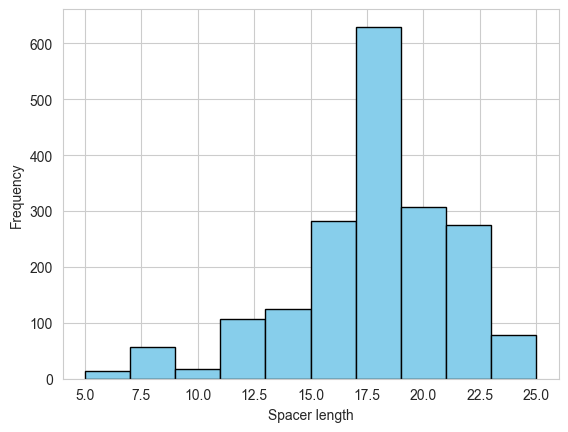

In [11]:
plt.hist(spacer, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Spacer length')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

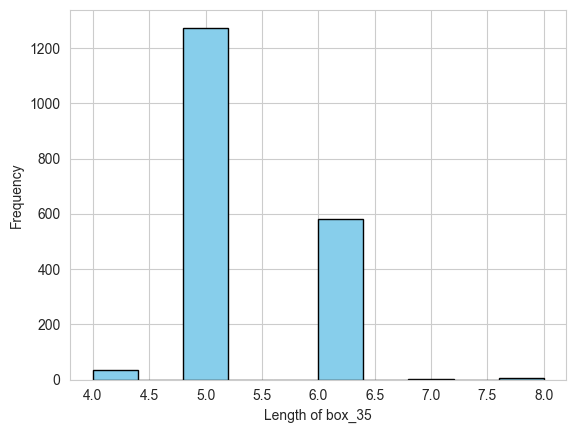

In [12]:
plt.hist(box_35_len, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Length of box_35')
plt.ylabel('Frequency')

### OHE

In [13]:
one_hot_tus = mg1655.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=10)

In [14]:
def one_hot_encode_sequence(left: int, right: int, strand: int) -> pd.Series:
    
        sequence = bitome_genbank.get_sequence(left, right, strand)
        one_hot_names = []
        one_hots = []
        for i, seq_base in enumerate(sequence):
            for base in 'ACGT':
                one_hot_names.append(f'{i}_{base}')
                if base == seq_base:
                    one_hots.append(1)
                else:
                    one_hots.append(0)

        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
        return one_hot_sequence

In [15]:
def reindex_one_hot(old_names, upstream, downstream, prefix=''):
    new_names = []
    for old_name,j in zip(old_names, [x for x in range(-upstream, downstream+1) for _ in range(4)]):
        ind, base = old_name.split('_')
        new_ind = j
        new_name = f'{prefix}{new_ind}_{base}'
        new_names.append(new_name)
    return new_names

### Spacer functions

In [16]:
def one_hot_sequence_left_padding(left: int) -> pd.Series:
    if left == 0:
        return pd.Series()
    
    one_hot_names = []
    one_hots = [] 
    for i in range(1,left+1):
        for base in ('ACGT'):
            one_hots.append(0)
            one_hot_names.append(f'{0-i}_{base}')
        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence

In [17]:
def one_hot_sequence_right_padding(right: int, spacer_len_oh: int) -> pd.Series:
    if right == 0:
        return pd.Series()
    
    one_hot_names = []
    one_hots = [] 
    for i in range(1,right+1):
        for base in ('ACGT'):
            one_hots.append(0)
            one_hot_names.append(f'{(int(spacer_len_oh/4)-1)+i}_{base}')
        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence

In [18]:
def reindex_one_hot_spacer(old_names, upstream, downstream, strand, prefix=''):
    new_names = []
    for old_name,j in zip(old_names, [x for x in range(-upstream, downstream+1) for _ in range(4)][::-1]):
        ind, base = old_name.split('_')
        new_ind = j
        new_name = f'{prefix}{new_ind}_{base}'
        new_names.append(new_name)
    return new_names

In [19]:
def generate_spacer_one_hot(tu_row):
    spacer_u, spacer_d = (tu_row.box_35_right+1, tu_row.box_10_left-1) if tu_row.strand == 1 else (
    tu_row.box_10_right+1, tu_row.box_35_left-1)
    spacer_oh = one_hot_encode_sequence(spacer_u, spacer_d, tu_row.strand)
    
    length = len(spacer_oh) // 4
    if length % 2 == 0:
        left = int((26 - length) / 2)
        right = int((26 - length) / 2)
    else:
        left = int((26 - length) / 2)
        right = int((26 - length) // 2) + 1
    spacer_ohh = pd.concat([one_hot_sequence_left_padding(left=left), spacer_oh,
                               one_hot_sequence_right_padding(right=right, spacer_len_oh=length)])

    return spacer_ohh

### MR OHE

In [20]:
tu = tu_table
def one_hot_encode_tu_promoters(local_align: bool = False,
                                    upstream: int = 0, downstream: int = 0,
                                    box_10_l: bool = False, box_10_r: bool = False,
                                    box_35_l: bool = False, box_35_r: bool = False, 
                                    tss: bool = False, tfbs_l: bool = False, tfbs_r: bool = False, spacer: bool = False,
                                    tss_up: int = 0, tss_dn: int = 0,
                                    box_10_l_up: int = 0, box_10_l_dn: int = 0,
                                    box_10_r_up: int = 0, box_10_r_dn: int = 0,
                                    box_35_l_up: int = 0, box_35_l_dn: int = 0,
                                    box_35_r_up: int = 0, box_35_r_dn: int = 0,
                                    ) -> pd.DataFrame:
    
        #Change this according to the dataframe
        tu_table = tu
        
        a = []
        tss_oh, box_10_l_oh, box_10_r_oh, box_35_l_oh, box_35_r_oh, spacer_ohh = [None] * 6
        
        if local_align:
            one_hot_index = []
            one_hot_rows = []
            tu_table_local_align = tu_table[
                (tu_table['tss'].notna()) &
                (tu_table['box_10_left'].notna()) &
                (tu_table['box_35_left'].notna())
            ]
            
            for tu_row in tu_table_local_align.itertuples():
                if spacer:
                    spacer_ohh = generate_spacer_one_hot(tu_row)
                    spacer_ohh.index = reindex_one_hot_spacer(spacer_ohh.index, 0, 25, strand = tu_row.strand, prefix='spacer_')
                
                if tss:
                    if tu_row.strand == 1:
                        tss_u, tss_d = tu_row.tss - tss_up, tu_row.tss + tss_dn
                    else:
                        tss_u, tss_d = tu_row.tss - tss_dn, tu_row.tss + tss_up
                    tss_oh = one_hot_encode_sequence(tss_u, tss_d, tu_row.strand)
                    tss_oh.index = reindex_one_hot(tss_oh.index, tss_up, tss_dn, prefix='tss_')
                        
                if box_10_l:
                    if tu_row.strand == 1:
                        box_10_l_u, box_10_l_d = tu_row.box_10_left - box_10_l_up, tu_row.box_10_left + box_10_l_dn
                    else:
                        box_10_l_u, box_10_l_d = tu_row.box_10_right - box_10_l_dn, tu_row.box_10_right + box_10_l_up
                    box_10_l_oh = one_hot_encode_sequence(box_10_l_u, box_10_l_d, tu_row.strand)
                    box_10_l_oh.index = reindex_one_hot(box_10_l_oh.index, box_10_l_up, box_10_l_dn, prefix='box_10_l_')
                           
                if box_10_r:
                    if tu_row.strand == 1:
                        box_10_r_u, box_10_r_d = tu_row.box_10_right - box_10_r_up, tu_row.box_10_right + box_10_r_dn
                    else:
                        box_10_r_u, box_10_r_d = tu_row.box_10_left - box_10_r_dn, tu_row.box_10_left + box_10_r_up
                    box_10_r_oh = one_hot_encode_sequence(box_10_r_u, box_10_r_d, tu_row.strand)
                    box_10_r_oh.index = reindex_one_hot(box_10_r_oh.index, box_10_r_up, box_10_r_dn, prefix='box_10_r_')
                                 
                if box_35_l:
                    if tu_row.strand == 1:
                        box_35_l_u, box_35_l_d = tu_row.box_35_left - box_35_l_up, tu_row.box_35_left + box_35_l_dn
                    else:
                        box_35_l_u, box_35_l_d = tu_row.box_35_right - box_35_l_dn, tu_row.box_35_right + box_35_l_up
                    box_35_l_oh = one_hot_encode_sequence(box_35_l_u, box_35_l_d, tu_row.strand)
                    box_35_l_oh.index = reindex_one_hot(box_35_l_oh.index, box_35_l_up, box_35_l_dn, prefix='box_35_l_')
                        
                if box_35_r:
                    if tu_row.strand == 1:
                        box_35_r_u, box_35_r_d = tu_row.box_35_right - box_35_r_up, tu_row.box_35_right + box_35_r_dn
                    else:
                        box_35_r_u, box_35_r_d = tu_row.box_35_left - box_35_r_dn, tu_row.box_35_left + box_35_r_up
                    box_35_r_oh = one_hot_encode_sequence(box_35_r_u, box_35_r_d, tu_row.strand)
                    box_35_r_oh.index = reindex_one_hot(box_35_r_oh.index, box_35_r_up, box_35_r_dn, prefix='box_35_r_')
                
                dfs_to_concat = [tss_oh, spacer_ohh, box_10_l_oh, box_10_r_oh, box_35_l_oh, box_35_r_oh]
                if any(df is not None for df in dfs_to_concat):
                    full_oh_row = pd.concat([df for df in dfs_to_concat if df is not None])
                
                one_hot_index.append(tu_row.Index)
                one_hot_rows.append(full_oh_row)

            one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)

        return one_hot_tu_df

In [21]:
one_hot_tus_local = one_hot_encode_tu_promoters(local_align=True, tss =True, tss_up = 5, tss_dn = 10, box_10_l=True, box_10_l_up = 5, box_10_l_dn = 0, box_10_r=True, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=True, box_35_l_up = 20, box_35_l_dn = 0, box_35_r=True, box_35_r_up = 5, box_35_r_dn = 5, spacer = True)

In [22]:
one_hot_tus_local

,tss_-5_A,tss_-5_C,tss_-5_G,tss_-5_T,tss_-4_A,tss_-4_C,tss_-4_G,tss_-4_T,tss_-3_A,tss_-3_C,...,box_35_r_3_G,box_35_r_3_T,box_35_r_4_A,box_35_r_4_C,box_35_r_4_G,box_35_r_4_T,box_35_r_5_A,box_35_r_5_C,box_35_r_5_G,box_35_r_5_T
ECK120008913,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
ECK120008914,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
ECK120008915,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
ECK120008916,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
ECK120008917,0,1,0,0,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ECK125257178,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
ECK125257179,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
ECK125257180,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
ECK125257181,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


## ML model

In [23]:
Xy_to_try = {}

In [24]:
gene_names_avg = []
gene_oh_rows_avg = []
gene_exps_avg = []
gene_exps_avg_ctrl = []
gene_exps_avg_all = []

gene_names_1tss = []
gene_oh_rows_1tss = []
gene_exps_1tss = []
gene_exps_1tss_ctrl = []
gene_exps_1tss_all = []

gene_names_local_avg = []
gene_oh_rows_local_avg = []
gene_exps_local_avg = []
gene_exps_local_avg_ctrl = []
gene_exps_local_avg_all = []

gene_names_local_1tss = []
gene_oh_rows_local_1tss = []
gene_exps_local_1tss = []
gene_exps_local_1tss_ctrl = []
gene_exps_local_1tss_all = []

for gene_row in mg1655.gene_table.itertuples():
    
    # handle the normal 1-hot
    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]
    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]
    gene_tpm = gene_row.tpm
    gene_tpm_ctrl = gene_row.tpm_ctrl
    gene_tpm_all = gene_row.tpm_all
    if tus_in_onehot and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_names_avg.append(gene_row.Index)
        gene_oh_rows_avg.append(tu_one_hot_avg)
        gene_exps_avg.append(gene_tpm)
        gene_exps_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_onehot) == 1:
            gene_names_1tss.append(gene_row.Index)
            gene_oh_rows_1tss.append(one_hot_tus.loc[tus_in_onehot[0]])
            gene_exps_1tss.append(gene_tpm)
            gene_exps_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_1tss_all.append(gene_tpm_all)
            
    # handle the local-aligned 1-hot
    tus_in_oh_loc = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus_local.index)]
    #print(tus_in_oh_loc)
    if tus_in_oh_loc and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots_loc = one_hot_tus_local.loc[tus_in_oh_loc, :]
        tu_one_hot_avg_loc = tu_one_hots_loc.mean(axis=0)
        gene_names_local_avg.append(gene_row.Index)
        gene_oh_rows_local_avg.append(tu_one_hot_avg_loc)
        gene_exps_local_avg.append(gene_tpm)
        gene_exps_local_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_local_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_oh_loc) == 1:
            #print(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_names_local_1tss.append(gene_row.Index)
            gene_oh_rows_local_1tss.append(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_exps_local_1tss.append(gene_tpm)
            gene_exps_local_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_local_1tss_all.append(gene_tpm_all)

X_avg = pd.DataFrame(gene_oh_rows_avg, index=gene_names_avg)
Xy_to_try['prom_avg__wt'] = (X_avg, pd.Series(gene_exps_avg, index=gene_names_avg))
Xy_to_try['prom_avg__ctrl'] = (X_avg, pd.Series(gene_exps_avg_ctrl, index=gene_names_avg))
Xy_to_try['prom_avg__all'] = (X_avg, pd.Series(gene_exps_avg_all, index=gene_names_avg))

X_1tss = pd.DataFrame(gene_oh_rows_1tss, index=gene_names_1tss)
Xy_to_try['1tss__wt'] = (X_1tss, pd.Series(gene_exps_1tss, index=gene_names_1tss))
Xy_to_try['1tss__ctrl'] = (X_1tss, pd.Series(gene_exps_1tss_ctrl, index=gene_names_1tss))
Xy_to_try['1tss__all'] = (X_1tss, pd.Series(gene_exps_1tss_all, index=gene_names_1tss))

X_local_avg = pd.DataFrame(gene_oh_rows_local_avg, index=gene_names_local_avg)
Xy_to_try['local_avg__wt'] = (X_local_avg, pd.Series(gene_exps_local_avg, index=gene_names_local_avg))
Xy_to_try['local_avg__ctrl'] = (X_local_avg, pd.Series(gene_exps_local_avg_ctrl, index=gene_names_local_avg))
Xy_to_try['local_avg__all'] = (X_local_avg, pd.Series(gene_exps_local_avg_all, index=gene_names_local_avg))

X_local_1tss = pd.DataFrame(gene_oh_rows_local_1tss, index=gene_names_local_1tss)
Xy_to_try['local_1tss__wt'] = (X_local_1tss, pd.Series(gene_exps_local_1tss, index=gene_names_local_1tss))
Xy_to_try['local_1tss__ctrl'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_ctrl, index=gene_names_local_1tss))
Xy_to_try['local_1tss__all'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_all, index=gene_names_local_1tss))

In [25]:
Xy_to_try = {
    'local_1tss__wt': Xy_to_try['local_1tss__wt'],
    'local_avg__wt': Xy_to_try['local_avg__wt']
}
Xy_to_try

{'local_1tss__wt': (       tss_-5_A  tss_-5_C  tss_-5_G  tss_-5_T  tss_-4_A  tss_-4_C  tss_-4_G  \
  b0002         0         0         0         1         1         0         0   
  b0003         0         0         0         1         1         0         0   
  b0004         0         0         0         1         1         0         0   
  b0025         0         1         0         0         0         0         1   
  b0034         0         0         1         0         1         0         0   
  ...         ...       ...       ...       ...       ...       ...       ...   
  b4388         0         1         0         0         1         0         0   
  b4389         0         1         0         0         1         0         0   
  b4392         1         0         0         0         0         1         0   
  b4393         0         0         0         1         0         1         0   
  b4396         0         1         0         0         1         0         0   
  
       

In [26]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try, random_state=42)

In [27]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
}

In [28]:
def profile_xy_and_models(xy_to_try: Dict[str, Tuple[pd.DataFrame, pd.Series]],
                          models_to_try: Dict[str, Any],
                          scoring: str = 'r2', n_cv: int = 5,
                          x_preprocessing: List[str] = None,
                          y_preprocessing: List[str] = None,
                          verbose: bool = True) -> Tuple[pd.DataFrame, plt.Axes, plt.Axes]:
    """
    This mega-function enables the testing of multiple ML models on multiple Xy datasets for an
    initial understanding of model/feature performances. Multiple different normalizations for the
    X and y can be specified. This function uses a cross-validation approach, so no distinct
    validation set is created (just a training set). Assumes that the xy passed in have already
    been split for training (you can use create_train_and_lockbox_sets for this)

    Output includes plots summarizing the training and testing scores for each of the model/xy
    combinations, as well as a DataFrame containing those same results for further processing.

    :param Dict[str, Tuple[pd.DataFrame, pd.Series]] xy_to_try: a dictionary containing the names
        (keys) and Xy combinations (values, as tuples) to try modeling
    :param Dict[str, Any] models_to_try: the ML models (sklearn estimators) to try
    :param str scoring: the scoring metric to use; defaults to r2
    :param int n_cv: the number of cross validations to perform
    :param List[str] x_preprocessing: a list of pre-processing steps to apply to the feature matrix.
        Options include: 'standard' (standardizing/z-scoring)
    :param List[str] y_preprocessing: a list of pre-processing steps to apply to the targets.
        Options include: 'standard' (standardizing/z-scoring), 'log' (log+1 transform), and
        'standard_log' (apply log then standard transforms in succession)
    :param bool verbose: indicate if status updates should be printed at relevant moments
    """

    # prepare a DataFrame to store the results of the cross-validated comparisons
    profile_result_df = pd.DataFrame(
        columns=['model', 'xy', 'train_score', 'val_score']
    )

    # iterate through model/XY combinations and run a cross-validation in each case
    for model_name, model in models_to_try.items():
        for xy_name, (x_train_raw, y_train_raw) in xy_to_try.items():

            # normalize the X and y as requested by the options;
            x_list = [('X_raw', x_train_raw)]
            if x_preprocessing is not None:
                for x_norm_scheme in x_preprocessing:
                    if x_norm_scheme == 'standard':
                        x_train_standard = StandardScaler().fit_transform(x_train_raw)
                        x_list.append(('X_standard', x_train_standard))
                    # add more x_norm_scheme here
                    else:
                        raise ValueError(f'X normalization scheme {x_norm_scheme} not recognized')
            y_list = [('y_raw', y_train_raw)]
            if y_preprocessing is not None:
                for y_norm_scheme in y_preprocessing:
                    if y_norm_scheme == 'standard':
                        y_train_standard = StandardScaler().fit_transform(
                            y_train_raw.values.reshape(-1, 1)
                        )
                        y_list.append(('y_standard', y_train_standard))
                    elif y_norm_scheme == 'log':
                        y_train_log = np.log2(y_train_raw.values + 1)
                        y_list.append(('y_log', y_train_log))
                    elif y_norm_scheme == 'log10':
                        y_train_log = np.log10(y_train_raw.values + 1).reshape(-1,1)
                        y_list.append(('y_log10', y_train_log))
                    elif y_norm_scheme == 'standard_log':
                        y_train_standard_log = StandardScaler().fit_transform(
                            np.log2(y_train_raw.values + 1).reshape(-1, 1)
                        )
                        y_list.append(('y_standard_log', y_train_standard_log))
                    # add more y_norm_scheme here
                    else:
                        raise ValueError(f'y normalization scheme {y_norm_scheme} not recognized')

            xy_final = {}
            for (x_lab, x_mat), (y_lab, y_mat) in itertools.product(x_list, y_list):
                xy_lab_final = f'{xy_name}__{x_lab}__{y_lab}'
                xy_final[xy_lab_final] = (x_mat, y_mat)

            for xy_full_name, (X_to_use, y_to_use) in xy_final.items():
                _verbose_print(f'{model_name}: {xy_full_name}', verbose)

                cv_result = cross_validate(model, X_to_use, y=y_to_use, cv=n_cv, scoring=scoring,
                                           return_train_score=True, n_jobs=4)

                cv_result_df = pd.DataFrame(data={
                                                'model': model_name,
                                                'xy': xy_full_name,
                                                'train_score': cv_result['train_score'],
                                                'val_score': cv_result['test_score']
                                            })

                profile_result_df = profile_result_df.append(cv_result_df)

    # plot the training and testing results
    _, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

    sns.boxplot(x='model', y='train_score', data=profile_result_df, hue='xy', dodge=True,
                fliersize=0, ax=ax_train)
    sns.swarmplot(x='model', y='train_score', data=profile_result_df, hue='xy', dodge=True,
                  color='black', ax=ax_train)
    handles_train, labels_train = ax_train.get_legend_handles_labels()
    ax_train.legend(handles_train[:int(len(handles_train)/2)],
                    labels_train[:int(len(labels_train)/2)], loc='center left',
                    bbox_to_anchor=(1.05, 0.5))
    ax_train.set_xlabel('')
    ax_train.set_ylabel(f'Training {scoring}', fontsize=13)
    ax_train.set_ylim(0, 1)

    sns.boxplot(x='model', y='val_score', data=profile_result_df, hue='xy', dodge=True,
                fliersize=0, ax=ax_val)
    sns.swarmplot(x='model', y='val_score', data=profile_result_df, hue='xy', dodge=True,
                  color='black', ax=ax_val)
    handles_val, labels_val = ax_val.get_legend_handles_labels()
    ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
                  loc='center left', bbox_to_anchor=(1.05, 0.5))
    ax_val.set_xlabel('')
    ax_val.set_ylabel(f'Validation {scoring}', fontsize=13)
    ax_val.set_ylim(0, 1)

    return profile_result_df, ax_train, ax_val


In [29]:
def _verbose_print(s: str, verbose: bool):
    """
    Print a string based on a Boolean toggle
    """
    if verbose:
        print(s)

ElasticNet: local_1tss__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ElasticNet: local_1tss__wt__X_raw__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ElasticNet: local_1tss__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ElasticNet: local_1tss__wt__X_standard__y_standard
ElasticNet: local_avg__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ElasticNet: local_avg__wt__X_raw__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ElasticNet: local_avg__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ElasticNet: local_avg__wt__X_standard__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_1tss__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_1tss__wt__X_raw__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_1tss__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_1tss__wt__X_standard__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_raw__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVR: local_avg__wt__X_standard__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_raw__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_1tss__wt__X_standard__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_raw__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


RF: local_avg__wt__X_standard__y_standard


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


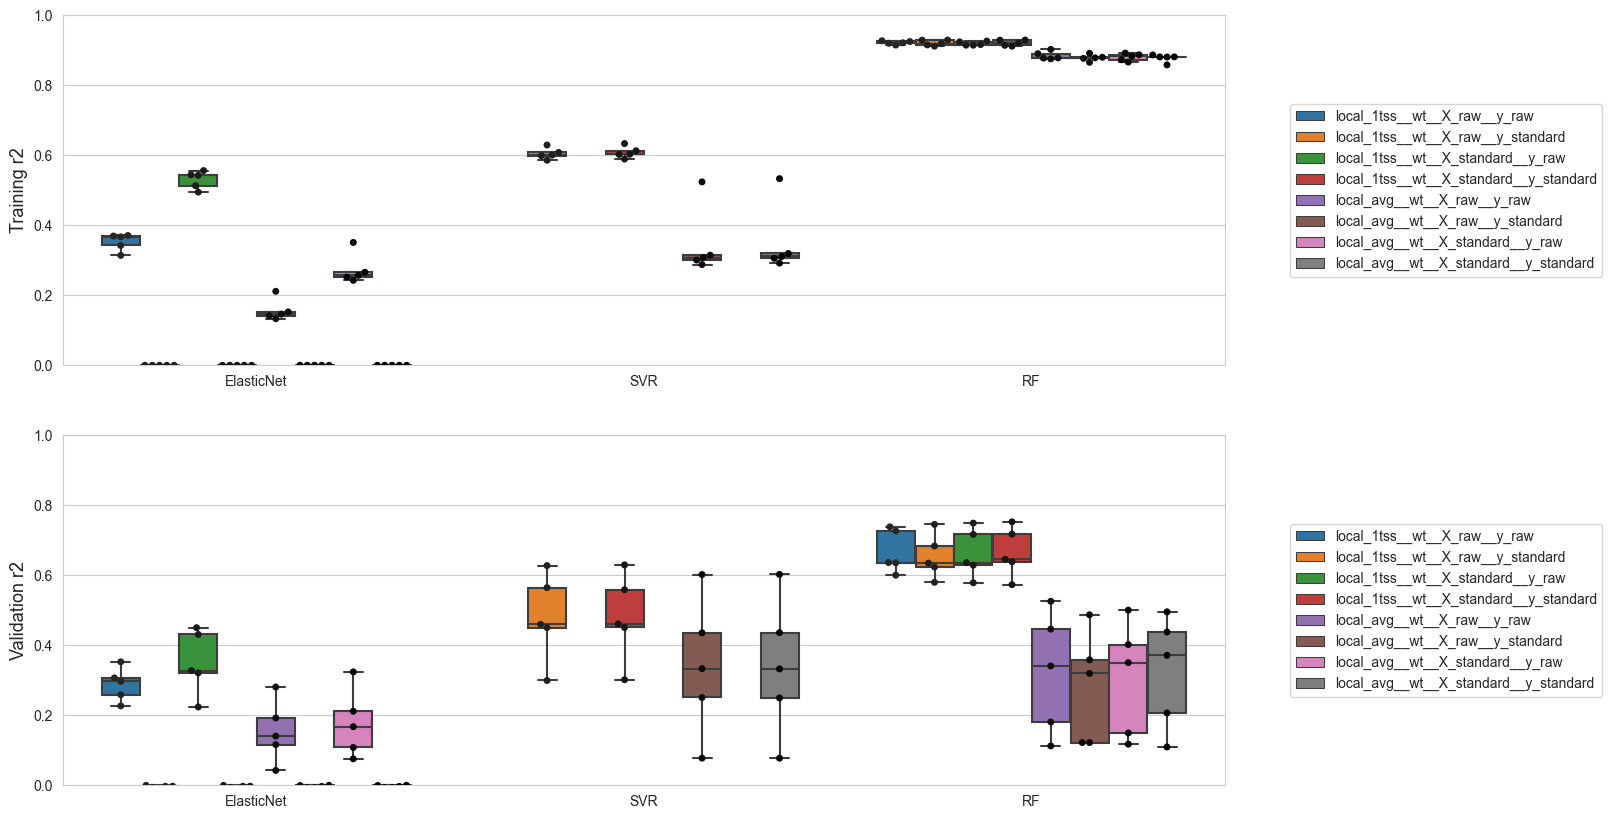

In [30]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing=['standard'], y_preprocessing=['standard'],
                                                           verbose=True)

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


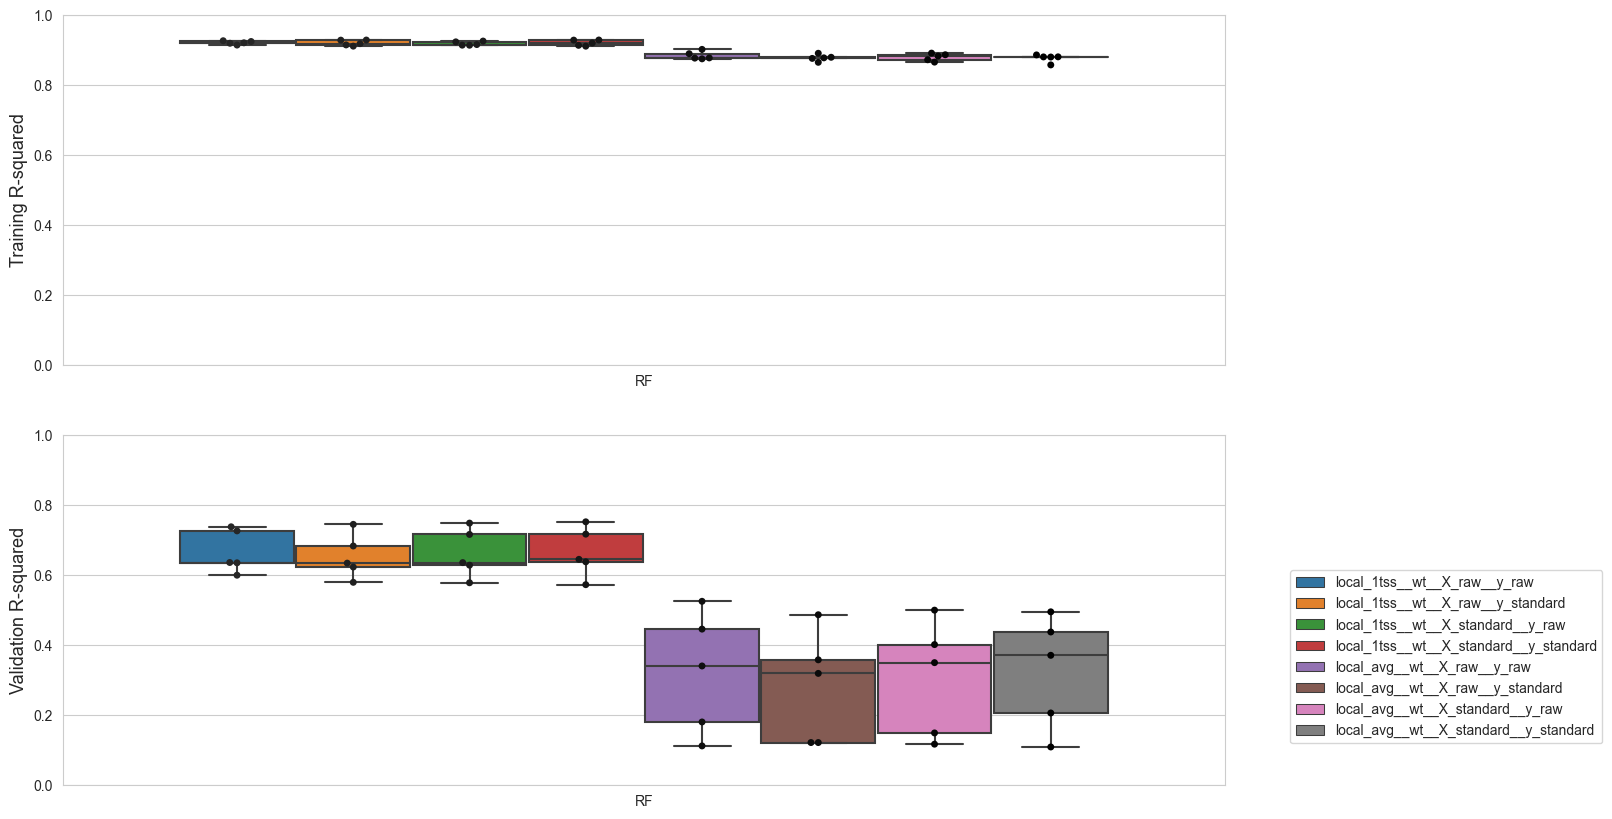

In [31]:
to_plot_df = model_profile_df[
    (model_profile_df['model'] == 'RF')
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_train)
sns.swarmplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_train)
ax_train.get_legend().remove()
ax_train.set_xlabel('')
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_val)
sns.swarmplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
              loc='lower left', bbox_to_anchor=(1.05, 0.1))
ax_val.set_xlabel('')
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')

In [32]:
x_oh_fi_raw = Xy_train['local_avg__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['local_avg__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


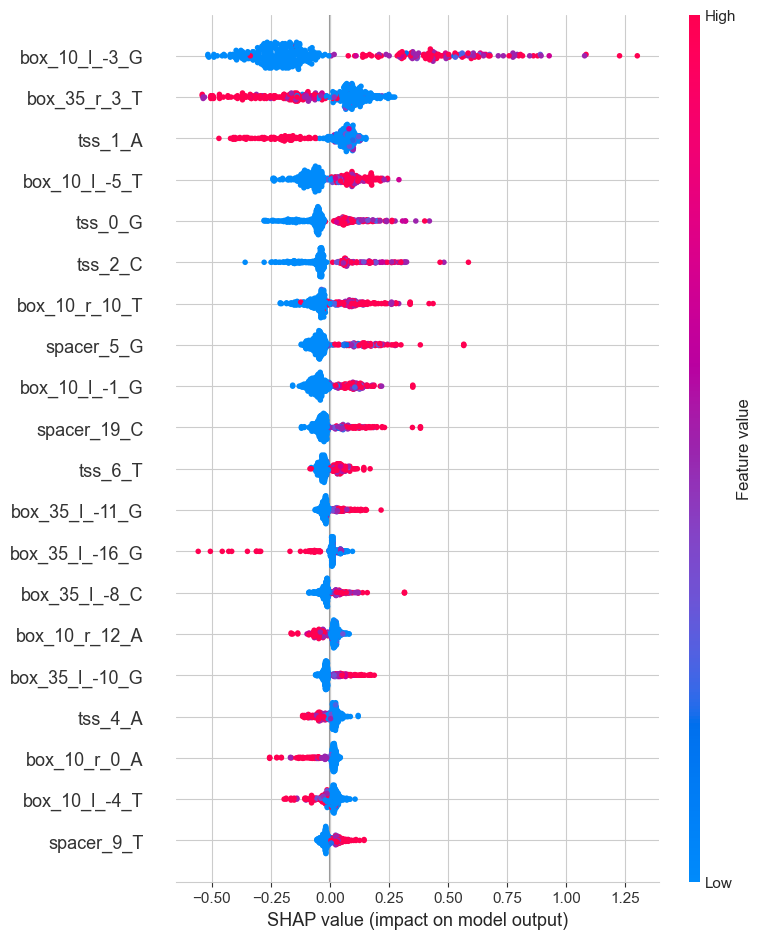

In [33]:
feature_importance(
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF']
)

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_raw, test_size=0.2, random_state = 42)

Text(0.5, 0.05, 'R-square: 0.43\nPearson R: 0.69 (P=1.31E-60)\nSpearman R: 0.55 (P=7.75E-34)')

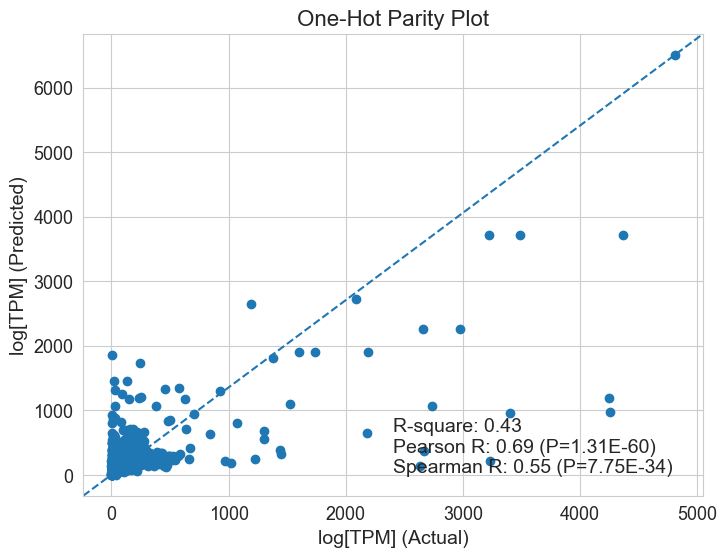

In [35]:
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
y_pred_log = np.log2(y_pred + 1)
y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

In [36]:
x_oh_fi_raw = Xy_train['local_1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['local_1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


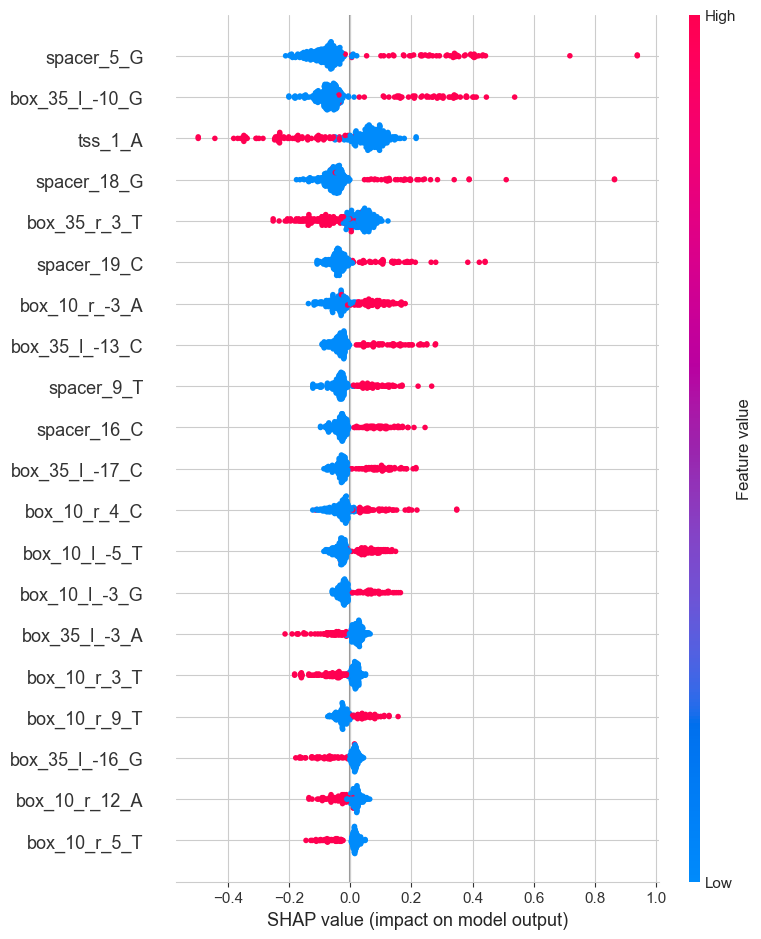

In [37]:
feature_importance(
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF']
)

In [38]:
# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_raw, test_size=0.2, random_state = 42)


Text(0.5, 0.05, 'R-square: 0.57\nPearson R: 0.76 (P=4.51E-55)\nSpearman R: 0.48 (P=9.26E-18)')

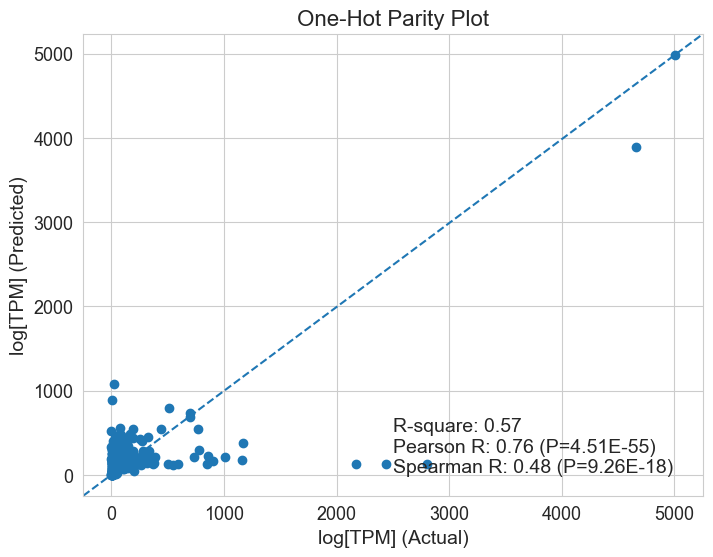

In [39]:
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
y_pred_log = np.log2(y_pred + 1)
y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

# Grouping by transcription unit/promoter 

#### Strand = -1

In [40]:
grouped_mini_dfs = {name: group for name, group in tu_table.groupby('name')}
grouped_mini_dfs['astCADBE']

,Unnamed: 0,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,,
ECK120008913,0,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,1,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,2,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0


In [41]:
#change this to the promoter/TU name of choice
name_to_extract = 'astCADBE'
indexes_to_extract = grouped_mini_dfs.get(name_to_extract, pd.DataFrame()).index

result_df = one_hot_tus_local.loc[indexes_to_extract]

result_df

,tss_-5_A,tss_-5_C,tss_-5_G,tss_-5_T,tss_-4_A,tss_-4_C,tss_-4_G,tss_-4_T,tss_-3_A,tss_-3_C,...,box_35_r_3_G,box_35_r_3_T,box_35_r_4_A,box_35_r_4_C,box_35_r_4_G,box_35_r_4_T,box_35_r_5_A,box_35_r_5_C,box_35_r_5_G,box_35_r_5_T
locus_tag,,,,,,,,,,,,,,,,,,,,,
ECK120008913,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
ECK120008914,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
ECK120008915,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


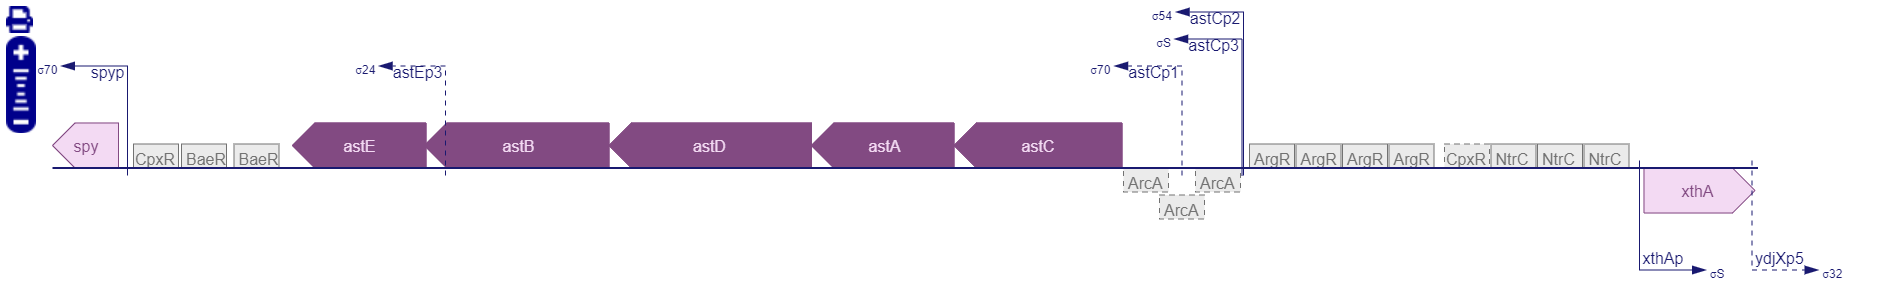

### Promoter: astCp1, tss: 1832013 

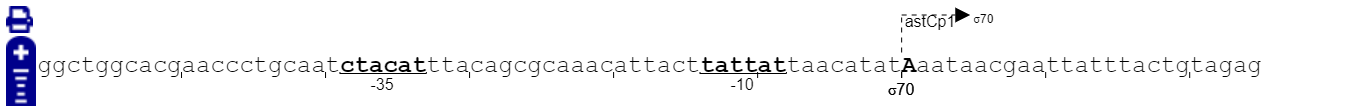

In [42]:
astCp1 = result_df.iloc[0]
filtered_values = astCp1[astCp1 == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-5_C
tss_-4_A
tss_-3_T
tss_-2_A
tss_-1_T
tss_0_A
tss_1_A
tss_2_A
tss_3_T
tss_4_A
tss_5_A
tss_6_C
tss_7_G
tss_8_A
tss_9_A
tss_10_T
spacer_22_T
spacer_21_T
spacer_20_A
spacer_19_C
spacer_18_A
spacer_17_G
spacer_16_C
spacer_15_G
spacer_14_C
spacer_13_A
spacer_12_A
spacer_11_A
spacer_10_C
spacer_9_A
spacer_8_T
spacer_7_T
spacer_6_A
spacer_5_C
spacer_4_T
box_10_l_-5_T
box_10_l_-4_T
box_10_l_-3_A
box_10_l_-2_C
box_10_l_-1_T
box_10_l_0_T
box_10_r_-5_T
box_10_r_-4_A
box_10_r_-3_T
box_10_r_-2_T
box_10_r_-1_A
box_10_r_0_T
box_10_r_1_T
box_10_r_2_A
box_10_r_3_A
box_10_r_4_C
box_10_r_5_A
box_10_r_6_T
box_10_r_7_A
box_10_r_8_T
box_10_r_9_A
box_10_r_10_A
box_10_r_11_A
box_10_r_12_T
box_10_r_13_A
box_10_r_14_A
box_10_r_15_C
box_35_l_-20_G
box_35_l_-19_C
box_35_l_-18_T
box_35_l_-17_G
box_35_l_-16_G
box_35_l_-15_C
box_35_l_-14_A
box_35_l_-13_C
box_35_l_-12_G
box_35_l_-11_A
box_35_l_-10_A
box_35_l_-9_C
box_35_l_-8_C
box_35_l_-7_C
box_35_l_-6_T
box_35_l_-5_G
box_35_l_-4_C
box_35_l_-3_A
box_35_l_-2_A


### Promoter: astCp2, tss: 1832044

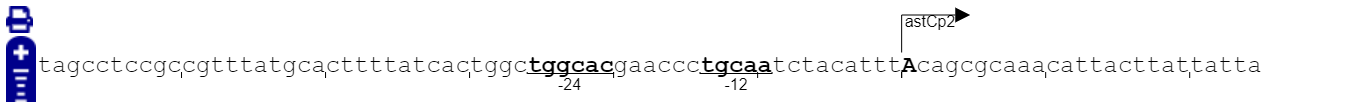

In [43]:
astCp2 = result_df.iloc[1]
filtered_values = astCp2[astCp2 == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-5_C
tss_-4_A
tss_-3_T
tss_-2_T
tss_-1_T
tss_0_A
tss_1_C
tss_2_A
tss_3_G
tss_4_C
tss_5_G
tss_6_C
tss_7_A
tss_8_A
tss_9_A
tss_10_C
spacer_15_G
spacer_14_A
spacer_13_A
spacer_12_C
spacer_11_C
spacer_10_C
box_10_l_-5_A
box_10_l_-4_A
box_10_l_-3_C
box_10_l_-2_C
box_10_l_-1_C
box_10_l_0_T
box_10_r_-5_C
box_10_r_-4_T
box_10_r_-3_G
box_10_r_-2_C
box_10_r_-1_A
box_10_r_0_A
box_10_r_1_T
box_10_r_2_C
box_10_r_3_T
box_10_r_4_A
box_10_r_5_C
box_10_r_6_A
box_10_r_7_T
box_10_r_8_T
box_10_r_9_T
box_10_r_10_A
box_10_r_11_C
box_10_r_12_A
box_10_r_13_G
box_10_r_14_C
box_10_r_15_G
box_35_l_-20_T
box_35_l_-19_A
box_35_l_-18_T
box_35_l_-17_G
box_35_l_-16_C
box_35_l_-15_A
box_35_l_-14_C
box_35_l_-13_T
box_35_l_-12_T
box_35_l_-11_T
box_35_l_-10_T
box_35_l_-9_A
box_35_l_-8_T
box_35_l_-7_C
box_35_l_-6_A
box_35_l_-5_C
box_35_l_-4_T
box_35_l_-3_G
box_35_l_-2_G
box_35_l_-1_C
box_35_l_0_T
box_35_r_-5_T
box_35_r_-4_G
box_35_r_-3_G
box_35_r_-2_C
box_35_r_-1_A
box_35_r_0_C
box_35_r_1_G
box_35_r_2_A
box_35_r_3_A
b

# Grouping by transcription unit/promoter

#### Strand = 1

In [44]:
grouped_mini_dfs = {name: group for name, group in tu_table.groupby('name')}
grouped_mini_dfs['nrdHIEF']

,Unnamed: 0,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,,
ECK120008916,3,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0


In [45]:
#change this to the promoter/TU name of choice
name_to_extract = 'nrdHIEF'
indexes_to_extract = grouped_mini_dfs.get(name_to_extract, pd.DataFrame()).index

result_df = one_hot_tus_local.loc[indexes_to_extract]

result_df

,tss_-5_A,tss_-5_C,tss_-5_G,tss_-5_T,tss_-4_A,tss_-4_C,tss_-4_G,tss_-4_T,tss_-3_A,tss_-3_C,...,box_35_r_3_G,box_35_r_3_T,box_35_r_4_A,box_35_r_4_C,box_35_r_4_G,box_35_r_4_T,box_35_r_5_A,box_35_r_5_C,box_35_r_5_G,box_35_r_5_T
locus_tag,,,,,,,,,,,,,,,,,,,,,
ECK120008916,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


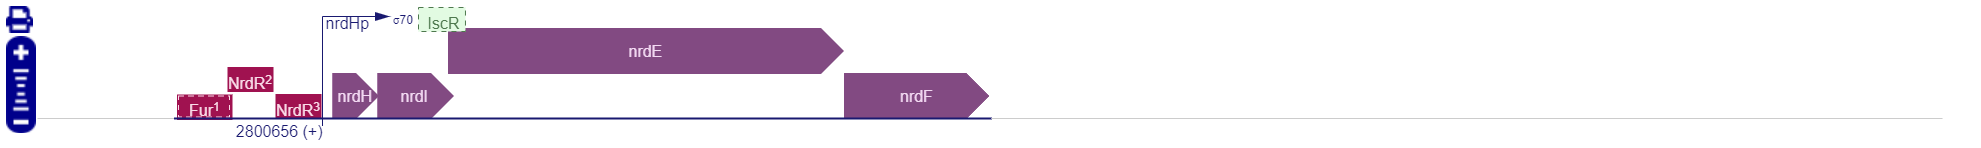

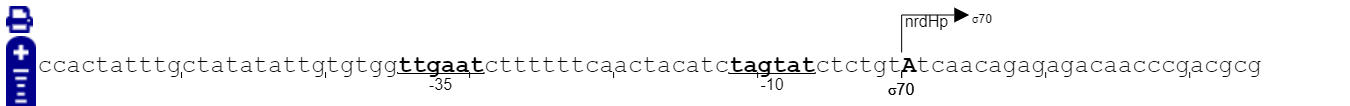

In [46]:
nrdHp = result_df.iloc[0]
filtered_values = nrdHp[nrdHp == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-5_T
tss_-4_C
tss_-3_T
tss_-2_G
tss_-1_T
tss_0_A
tss_1_T
tss_2_C
tss_3_A
tss_4_A
tss_5_C
tss_6_A
tss_7_G
tss_8_A
tss_9_G
tss_10_A
spacer_21_C
spacer_20_T
spacer_19_T
spacer_18_T
spacer_17_T
spacer_16_T
spacer_15_T
spacer_14_C
spacer_13_A
spacer_12_A
spacer_11_C
spacer_10_T
spacer_9_A
spacer_8_C
spacer_7_A
spacer_6_T
spacer_5_C
box_10_l_-5_A
box_10_l_-4_C
box_10_l_-3_A
box_10_l_-2_T
box_10_l_-1_C
box_10_l_0_T
box_10_r_-5_T
box_10_r_-4_A
box_10_r_-3_G
box_10_r_-2_T
box_10_r_-1_A
box_10_r_0_T
box_10_r_1_C
box_10_r_2_T
box_10_r_3_C
box_10_r_4_T
box_10_r_5_G
box_10_r_6_T
box_10_r_7_A
box_10_r_8_T
box_10_r_9_C
box_10_r_10_A
box_10_r_11_A
box_10_r_12_C
box_10_r_13_A
box_10_r_14_G
box_10_r_15_A
box_35_l_-20_A
box_35_l_-19_T
box_35_l_-18_T
box_35_l_-17_T
box_35_l_-16_G
box_35_l_-15_C
box_35_l_-14_T
box_35_l_-13_A
box_35_l_-12_T
box_35_l_-11_A
box_35_l_-10_T
box_35_l_-9_A
box_35_l_-8_T
box_35_l_-7_T
box_35_l_-6_G
box_35_l_-5_T
box_35_l_-4_G
box_35_l_-3_T
box_35_l_-2_G
box_35_l_-1_G
box_35_l_